In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from common_import import *

/home/hrai/miniconda3/envs/motionbert/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### Action index
https://github.com/JimmySuen/integral-human-pose/blob/master/pytorch_projects/common_pytorch/dataset/hm36.py#L32

In [21]:
actions = ["Directions","Discussion","Eating","Greeting",
           "Phoning","Photo","Posing","Purchases",
           "Sitting","SittingDown","Smoking","Waiting",
           "WalkDog","Walking","WalkTogether"]

# 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16

### LCN dataset
https://drive.google.com/drive/folders/1l-Xn5wiDd5ZcnClcqgiBCjHPp4ZjVVsY

In [2]:
h36m_train = readpkl('/home/hrai/codes/MotionBERT/data/motion3d/h36m_train.pkl')
h36m_test = readpkl('/home/hrai/codes/MotionBERT/data/motion3d/h36m_test.pkl')

In [118]:
len(h36m_train), len(h36m_test)

(1559752, 566920)

### VideoPose ~ PoseAug ~ PosynDA dataset

In [ ]:
from hpe_library.posynda_utils import Human36mDataset
h36m_dataset = Human36mDataset('/home/hrai/codes/hpe_library/data/data_3d_h36m.npz', remove_static_joints=True)._data

num_frames_train = 0
num_frames_test = 0
for subject in h36m_dataset.keys():
    for action in h36m_dataset[subject].keys():
        if subject in ['S1', 'S5', 'S6', 'S7', 'S8']:
            num_frames_train += h36m_dataset[subject][action]['positions'].shape[0]
        elif subject in ['S9', 'S11']:
            num_frames_test += h36m_dataset[subject][action]['positions'].shape[0]
print(num_frames_train*4, num_frames_test*4)

### Our dataset

In [2]:
data_type_list = ['source_list', 'cam_param',
                  'cam_3d', 'img_2d',
                  'img_3d', 'scale_factor', 'img_25d',
                  ]
overwrite_list = []
dataset_name = 'h36m'
data_aug = default_data_aug.copy()
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True, data_aug=data_aug)

[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M img_2d...
[overwrite: False] ==> Loading H36M img_3d...
[overwrite: False] ==> Loading H36M scale_factor...
[overwrite: False] ==> Loading H36M img_25d...


In [112]:
num_frames_train = 0
num_frames_test = 0
source_list = data['source_list'].copy()
for source in source_list:
    subject, cam_id, action = split_source_name(source, 'h36m')
    if subject in ['S1', 'S5', 'S6', 'S7', 'S8']:
        num_frames_train += len(data['cam_3d'][subject][action][cam_id])
    elif subject in ['S9', 'S11']:
        num_frames_test += len(data['cam_3d'][subject][action][cam_id])
print(num_frames_train, num_frames_test)

1559752 543344


### Analysis

In [16]:
len(h36m_train)

1559752

In [ ]:
action_idxs = {}
total_frames = 0
for action in tqdm(actions):
    action_idxs[action] = []
    for i in range(0, len(h36m_train)):
        if h36m_train[i]['action'] == actions.index(action)+2:
            action_idxs[action].append(i)
    # print(action, len(action_idxs[action]))
    total_frames += len(action_idxs[action])
print(total_frames)

  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:00<00:06,  2.23it/s]

Directions 100936


 13%|█▎        | 2/15 [00:00<00:05,  2.22it/s]

Discussion 158788


 20%|██        | 3/15 [00:01<00:05,  2.20it/s]

Eating 109424


 27%|██▋       | 4/15 [00:01<00:05,  2.18it/s]

Greeting 72436


 33%|███▎      | 5/15 [00:02<00:04,  2.14it/s]

Phoning 115832


 40%|████      | 6/15 [00:02<00:04,  2.12it/s]

Photo 69468


 47%|████▋     | 7/15 [00:03<00:03,  2.09it/s]

Posing 63080


 53%|█████▎    | 8/15 [00:03<00:03,  2.05it/s]

Purchases 116472


 60%|██████    | 9/15 [00:04<00:02,  2.01it/s]

Sitting 129232


 67%|██████▋   | 10/15 [00:04<00:02,  1.98it/s]

SittingDown 133252


 73%|███████▎  | 11/15 [00:05<00:02,  1.95it/s]

Smoking 76048


 80%|████████  | 12/15 [00:05<00:01,  1.90it/s]

Waiting 115296


 87%|████████▋ | 13/15 [00:06<00:01,  1.86it/s]

WalkDog 132744


 93%|█████████▎| 14/15 [00:07<00:00,  1.83it/s]

Walking 79412


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]

WalkTogether 87332
1559752


In [33]:
len(action_idxs['Walking'])

79412

In [58]:
action_idxs['Walking'][1000]

225596

In [59]:
example = h36m_train[action_idxs['Walking'][2000]]
source = example['image_path'].split('/')[0]
frame_num = example['imageid']
subject = example['subject']
if subject in [1, 5, 6, 7, 8]: data_type = 'train'
else: data_type = 'test'

In [64]:
cam_3d = example['joint_3d_camera']
root_pos = cam_3d[0]
img_3d = example['joint_3d_image']
cam_3d_hat = cam_3d.copy() - cam_3d[0]
img_3d_hat = img_3d.copy() - img_3d[0]
fx, fy, cx, cy = example['camera_param']['fx'], example['camera_param']['fy'], example['camera_param']['cx'], example['camera_param']['cy']
intrinsic = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
img_2d = projection(cam_3d, intrinsic)
scale_factor = (example['box'][2] - example['box'][0]) / 2000.0
cam_3d_retrieved = img_3d_hat / scale_factor + root_pos
cam_3d_retrieved_hat = cam_3d_retrieved - cam_3d_retrieved[0]
img_2d_retrieved = projection(cam_3d_retrieved, intrinsic)
scale_factor

/tmp/ipykernel_1150606/3424195270.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  intrinsic = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])


0.16723237391420334

In [61]:
img_3d[...,:2] - img_2d[...,:2]

array([[array([0.]), array([0.])],
       [array([0.]), array([5.68434189e-14])],
       [array([-1.13686838e-13]), array([0.])],
       [array([0.]), array([0.])],
       [array([-1.13686838e-13]), array([0.])],
       [array([0.]), array([5.68434189e-14])],
       [array([0.]), array([-5.68434189e-14])],
       [array([0.]), array([0.])],
       [array([0.]), array([0.])],
       [array([1.13686838e-13]), array([0.])],
       [array([0.]), array([0.])],
       [array([0.]), array([-5.68434189e-14])],
       [array([0.]), array([0.])],
       [array([0.]), array([-5.68434189e-14])],
       [array([0.]), array([-5.68434189e-14])],
       [array([1.13686838e-13]), array([0.])],
       [array([0.]), array([5.68434189e-14])]], dtype=object)

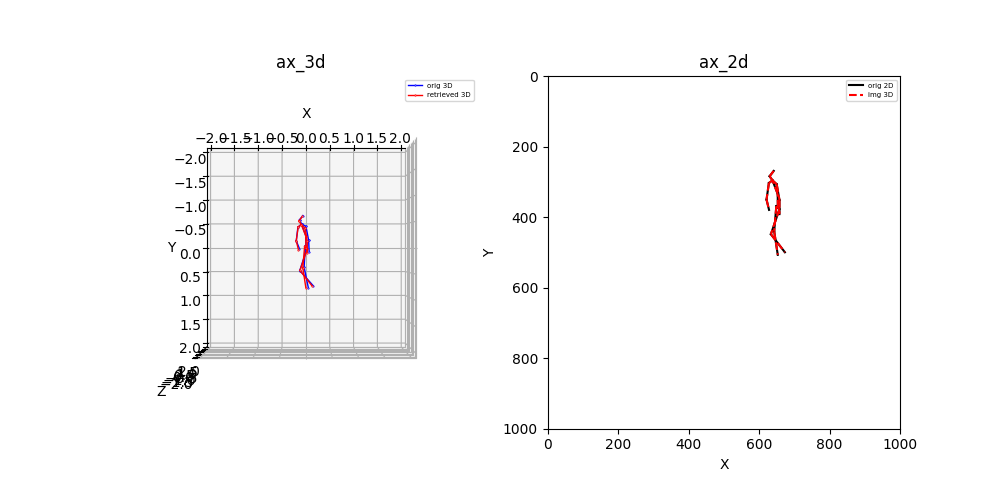

In [66]:
%matplotlib widget
# check original train data

configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam'},
    'ax_2d': {'type': '2d', 'loc': 122, 'W': 1000, 'H': 1000},
    #'ax_2d_norm': {'type': '2d', 'loc': 122, 'normalize': True},
}

fig, axs = generate_axes(0, configs, figsize=[10, 5], fig_title='')
plot_pose_setting = [
    ('ax_3d', cam_3d_hat/1000, {'color': 'b', 'label': 'orig 3D'}),
    ('ax_3d', cam_3d_retrieved_hat/1000, {'color': 'r', 'label': 'retrieved 3D'}),
    ('ax_2d', img_2d, {'color': 'k', 'label': 'orig 2D'}),
    ('ax_2d', img_3d, {'color': 'r', 'label': 'img 3D', 'linestyle': '--'}),
    # ('ax_2d_norm', joint_2d_norm, {'color': '', 'label': 'orig 2D'}),
    # ('ax_2d_norm', img_2d_norm, {'color': 'k', 'label': 'cam 2D'}),
]
general_plot_func(axs, configs, plot_pose_setting, 0)
plt.show()

### MotionBERT dataset

In [3]:
data_path = '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_cam_3d.pkl' # '/home/hrai/codes/MotionBERT/data/motion3d/h36m_sh_conf_cam_source_final.pkl'
h36m_sh = readpkl(data_path)

In [4]:
print(h36m_sh.keys())
print(h36m_sh['train'].keys())
print(h36m_sh['test'].keys())
train_source_list = list(set(list(h36m_sh['train']['source'])))
test_source_list = list(set(list(h36m_sh['test']['source'])))
test_action_list = list(set(list(h36m_sh['test']['action'])))
print(train_source_list)

len(h36m_sh['train']['joint_2d']), len(h36m_sh['test']['joint_2d'])

dict_keys(['train', 'test'])
dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'camera_name', 'source', 'joint3d_camera'])
dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'joint3d_camera'])
['s_08_act_06_cam_01', 's_06_act_15_cam_04', 's_01_act_06_cam_03', 's_01_act_07_cam_01', 's_01_act_12_cam_04', 's_05_act_16_cam_04', 's_07_act_09_cam_01', 's_07_act_12_cam_02', 's_07_act_05_cam_04', 's_05_act_12_cam_04', 's_08_act_03_cam_01', 's_08_act_10_cam_04', 's_07_act_04_cam_01', 's_07_act_13_cam_01', 's_07_act_13_cam_04', 's_06_act_02_cam_01', 's_06_act_06_cam_03', 's_01_act_16_cam_04', 's_06_act_12_cam_03', 's_05_act_07_cam_03', 's_08_act_04_cam_02', 's_08_act_05_cam_04', 's_08_act_09_cam_02', 's_01_act_15_cam_02', 's_08_act_05_cam_03', 's_06_act_13_cam_04', 's_05_act_08_cam_03', 's_07_act_11_cam_02', 's_08_act_07_cam_01', 's_05_act_02_cam_03', 's_01_act_15_cam_04', 's_01_act_04_cam_01', 's_07_act_02_cam_04', 's

(1559752, 566920)

### Add joint_3d_camera 

In [73]:
source

's_01_act_02_cam_01'

In [ ]:
idx_dict = {}

for i, item in tqdm(enumerate(h36m_train)):
    subject = item['subject']
    action = item['action']
    cameraid = item['cameraid'] + 1
    image_path = item['image_path']
    source = f"s_{subject:02d}_act_{action:02d}_cam_{cameraid:02d}"
    if source not in idx_dict:
        idx_dict[source] = []
    idx_dict[source].append(i)

355489it [00:00, 897065.49it/s]

1559752it [00:01, 918643.16it/s]


In [100]:
idx_dict.keys()

dict_keys(['s_01_act_02_cam_01', 's_01_act_02_cam_02', 's_01_act_02_cam_03', 's_01_act_02_cam_04', 's_01_act_03_cam_01', 's_01_act_03_cam_02', 's_01_act_03_cam_03', 's_01_act_03_cam_04', 's_01_act_04_cam_01', 's_01_act_04_cam_02', 's_01_act_04_cam_03', 's_01_act_04_cam_04', 's_01_act_05_cam_01', 's_01_act_05_cam_02', 's_01_act_05_cam_03', 's_01_act_05_cam_04', 's_01_act_06_cam_01', 's_01_act_06_cam_02', 's_01_act_06_cam_03', 's_01_act_06_cam_04', 's_01_act_07_cam_01', 's_01_act_07_cam_02', 's_01_act_07_cam_03', 's_01_act_07_cam_04', 's_01_act_08_cam_01', 's_01_act_08_cam_02', 's_01_act_08_cam_03', 's_01_act_08_cam_04', 's_01_act_09_cam_01', 's_01_act_09_cam_02', 's_01_act_09_cam_03', 's_01_act_09_cam_04', 's_01_act_10_cam_01', 's_01_act_10_cam_02', 's_01_act_10_cam_03', 's_01_act_10_cam_04', 's_01_act_11_cam_01', 's_01_act_11_cam_02', 's_01_act_11_cam_03', 's_01_act_11_cam_04', 's_01_act_12_cam_01', 's_01_act_12_cam_02', 's_01_act_12_cam_03', 's_01_act_12_cam_04', 's_01_act_13_cam_01',

In [111]:
for source in tqdm(idx_dict.keys()):
    # print(source, len(idx_dict[source]))
    idxs_h36m_sh = np.where(np.array(h36m_sh['train']['source']) == source)[0]
    num_frames_h36m_sh = len(idxs_h36m_sh)
    assert len(idx_dict[source]) == num_frames_h36m_sh, f"{len(idx_dict[source])} != {num_frames_h36m_sh}"
    break

  0%|          | 0/300 [00:00<?, ?it/s]


In [114]:
idx_dict[source][-1], idxs_h36m_sh[-1]

(7143, 7143)

In [131]:
for frame_num in range(100):
    print((h36m_sh['test']['joint3d_image'][frame_num] - h36m_test[frame_num]['joint_3d_image']).mean())
    scale_factor = scale_factor = (h36m_test[frame_num]['box'][2] - h36m_test[frame_num]['box'][0]) / 2000.0
    print((h36m_sh['test']['2.5d_factor'][frame_num] - 1/scale_factor))

5.906609673262822e-07
-0.11306493778955584
1.8805751507057842e-06
-0.11305343366315057
4.2594383915386784e-07
-0.11302110812425248
-2.4633623177013745e-07
-0.11300500734170349
2.5026536619100895e-07
-0.11303170469466117
7.679356051539102e-07
-0.11298912315574139
-3.919433380638941e-07
-0.11294425415147469
-2.1097818094914672e-06
-0.11285188400955448
1.9716214098912578e-06
-0.11273031512015308
-2.356144609804178e-06
-0.11260076397286323
1.503943151278947e-07
-0.1124615180901829
-2.2167459662216737e-07
-0.11221925775353547
5.895289539412912e-07
-0.11193797852997722
7.606469939578408e-07
-0.11156316708890657
-6.838558918619743e-07
-0.11116820041573483
2.9907367994766506e-07
-0.11066532284555564
-1.0736674767118295e-06
-0.1099467788061732
-4.757266524417029e-07
-0.10913187144709457
3.082201958583411e-07
-0.10827311822515906
1.7061454955589674e-07
-0.10716128044377715
1.6335175265780322e-06
-0.10605101887312429
6.113882294551545e-08
-0.10476668038871573
-9.257466755701615e-07
-0.10327160179

In [166]:
len(h36m_sh['train']['joint3d_camera'])/2

1843213.5

In [9]:
h36m_sh['train']['joint3d_camera'] = []
for i, item in tqdm(enumerate(h36m_train)):
    fx, fy, cx, cy = item['camera_param']['fx'], item['camera_param']['fy'], item['camera_param']['cx'], item['camera_param']['cy']
    intrinsic = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    img_2d = projection(item['joint_3d_camera'], intrinsic)
    h36m_sh['train']['joint3d_camera'].append(item['joint_3d_camera'])
    h36m_sh['train']['joint_2d'][i] = img_2d[...,:2]

0it [00:00, ?it/s]/tmp/ipykernel_1175993/3320208624.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  intrinsic = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
16481it [00:01, 8684.36it/s]

1559752it [02:59, 8687.79it/s]


In [4]:
h36m_sh['test']['joint3d_camera'] = []
for i, item in tqdm(enumerate(h36m_test)):
    fx, fy, cx, cy = item['camera_param']['fx'], item['camera_param']['fy'], item['camera_param']['cx'], item['camera_param']['cy']
    intrinsic = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    img_2d = projection(item['joint_3d_camera'], intrinsic)
    h36m_sh['test']['joint3d_camera'].append(item['joint_3d_camera'])
    h36m_sh['test']['joint_2d'][i] = img_2d[...,:2]

0it [00:00, ?it/s]/tmp/ipykernel_1175993/654005250.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  intrinsic = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
6961it [00:00, 8669.46it/s]

566920it [01:04, 8811.17it/s]


In [48]:
frame_num = 500000
#img_2d = h36m_sh['test']['joint_2d'][frame_num].copy()
fx, fy, cx, cy = h36m_test[frame_num]['camera_param']['fx'], h36m_test[frame_num]['camera_param']['fy'], h36m_test[frame_num]['camera_param']['cx'], h36m_test[frame_num]['camera_param']['cy']
intrinsic = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])


cam_3d = h36m_sh['test']['joint3d_camera'][frame_num].copy()
img_2d = h36m_sh['test']['joint_2d'][frame_num].copy()
img_3d = h36m_sh['test']['joint3d_image'][frame_num].copy()
new_img_3d = cam_3d / scale_factor
new_img_3d[:, 0] += cx
new_img_3d[:, 1] += cy
new_img_3d[:, 2] -= new_img_3d[0, 2]
img_25d = h36m_sh['test']['joints_2.5d_image'][frame_num].copy()
scale_factor = h36m_sh['test']['2.5d_factor'][frame_num].copy()
cam_3d_hat = cam_3d.copy() - cam_3d[0]
img_3d_hat = img_3d.copy() - img_3d[0]
img_25d_hat = img_25d.copy() - img_25d[0]

/tmp/ipykernel_1226863/781887591.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  intrinsic = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])


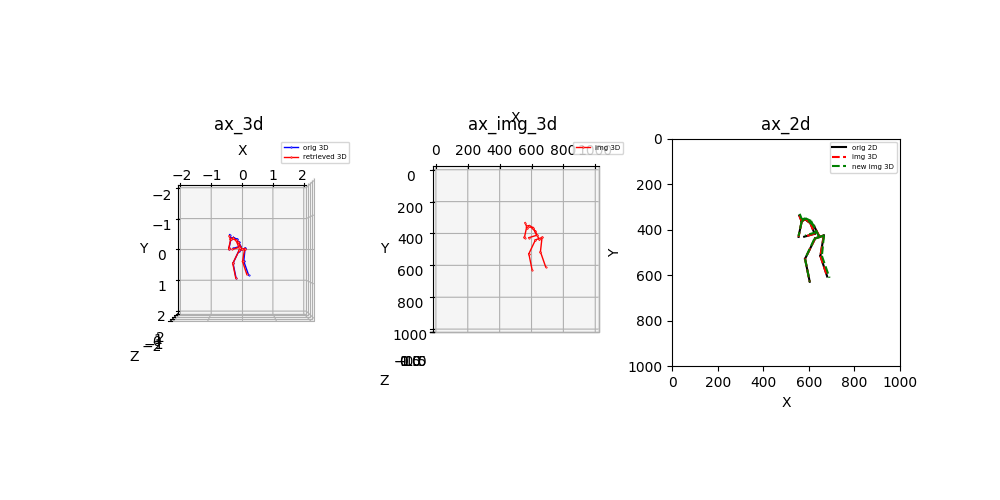

In [52]:
%matplotlib widget
# check original train data

configs = {
    'ax_3d': {'type': '3d', 'loc': 131, 'mode': 'cam'},
    'ax_img_3d': {'type': '3d', 'loc': 132,  'mode': 'cam', 'xlim': [0, 1000], 'ylim': [0, 1000], 'zlim': [-1, 1]},
    'ax_2d': {'type': '2d', 'loc': 133, 'W': 1000, 'H': 1000},
    #'ax_2d_norm': {'type': '2d', 'loc': 122, 'normalize': True},
}

fig, axs = generate_axes(0, configs, figsize=[10, 5], fig_title='')
plot_pose_setting = [
    ('ax_3d', cam_3d_hat/1000, {'color': 'b', 'label': 'orig 3D'}),
    ('ax_3d', img_25d_hat/1000, {'color': 'r', 'label': 'retrieved 3D'}),
    ('ax_img_3d', new_img_3d, {'color': 'r', 'label': 'img 3D'}),
    ('ax_2d', img_2d, {'color': 'k', 'label': 'orig 2D'}),
    ('ax_2d', img_3d, {'color': 'r', 'label': 'img 3D', 'linestyle': '--'}),
    ('ax_2d', new_img_3d, {'color': 'g', 'label': 'new img 3D', 'linestyle': '--'}),
    # ('ax_2d_norm', joint_2d_norm, {'color': '', 'label': 'orig 2D'}),
    # ('ax_2d_norm', img_2d_norm, {'color': 'k', 'label': 'cam 2D'}),
]
general_plot_func(axs, configs, plot_pose_setting, 0)
plt.show()

In [10]:
new_h36m_gt_path = '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_cam_3d.pkl'
savepkl(h36m_sh, new_h36m_gt_path)

### change joint3d_image from joint3d_camera

In [57]:
for i, item in tqdm(enumerate(h36m_train)):
    fx, fy, cx, cy = item['camera_param']['fx'], item['camera_param']['fy'], item['camera_param']['cx'], item['camera_param']['cy']
    scale_factor = (item['box'][2] - item['box'][0]) / 2000.0
    cam_3d = item['joint_3d_camera']
    #img_2d = projection(cam_3d, intrinsic)

    new_img_3d = cam_3d * scale_factor
    new_img_3d[:, 0] += cx
    new_img_3d[:, 1] += cy
    new_img_3d[:, 2] -= new_img_3d[0, 2]
    h36m_sh['train']['joint3d_image'][i] = new_img_3d

0it [00:00, ?it/s]

1559752it [00:09, 161829.46it/s]


In [64]:
for i, item in tqdm(enumerate(h36m_test)):
    fx, fy, cx, cy = item['camera_param']['fx'], item['camera_param']['fy'], item['camera_param']['cx'], item['camera_param']['cy']
    scale_factor = (item['box'][2] - item['box'][0]) / 2000.0
    cam_3d = item['joint_3d_camera']
    #img_2d = projection(cam_3d, intrinsic)

    new_img_3d = cam_3d * scale_factor
    new_img_3d[:, 0] += cx
    new_img_3d[:, 1] += cy
    new_img_3d[:, 2] -= new_img_3d[0, 2]
    h36m_sh['test']['joint3d_image'][i] = new_img_3d
    h36m_sh['test']['2.5d_factor'][i] = 1/scale_factor

0it [00:00, ?it/s]

566920it [00:03, 146608.48it/s]


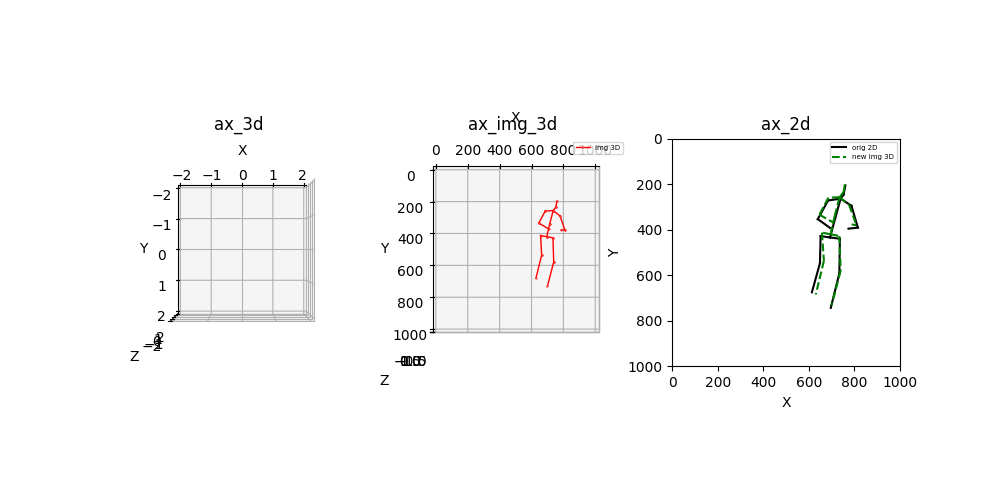

In [ ]:
%matplotlib widget
# check original train data
img_2d = projection(cam_3d, intrinsic)

configs = {
    'ax_3d': {'type': '3d', 'loc': 131, 'mode': 'cam'},
    'ax_img_3d': {'type': '3d', 'loc': 132,  'mode': 'cam', 'xlim': [0, 1000], 'ylim': [0, 1000], 'zlim': [-1, 1]},
    'ax_2d': {'type': '2d', 'loc': 133, 'W': 1000, 'H': 1000},
    #'ax_2d_norm': {'type': '2d', 'loc': 122, 'normalize': True},
}

fig, axs = generate_axes(3, configs, figsize=[10, 5], fig_title='')
plot_pose_setting = [
    #('ax_3d', cam_3d_hat/1000, {'color': 'b', 'label': 'orig 3D'}),
    #('ax_3d', img_25d_hat/1000, {'color': 'r', 'label': 'retrieved 3D'}),
    ('ax_img_3d', new_img_3d, {'color': 'r', 'label': 'img 3D'}),
    ('ax_2d', img_2d, {'color': 'k', 'label': 'orig 2D'}),
    #('ax_2d', img_3d, {'color': 'r', 'label': 'img 3D', 'linestyle': '--'}),
    ('ax_2d', new_img_3d, {'color': 'g', 'label': 'new img 3D', 'linestyle': '--'}),
    # ('ax_2d_norm', joint_2d_norm, {'color': '', 'label': 'orig 2D'}),
    # ('ax_2d_norm', img_2d_norm, {'color': 'k', 'label': 'cam 2D'}),
]
general_plot_func(axs, configs, plot_pose_setting, 0)
plt.show()

In [65]:
new_h36m_gt_path = '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_cam_3d_joint3d_image_modified.pkl'
savepkl(h36m_sh, new_h36m_gt_path)